In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

drop_unnamed = lambda x: x.loc[:, ~x.columns.str.contains(".*Unnamed.*")]


def wide2tall(df, infer_model: bool = True):
    df = drop_unnamed(df)
    df = df.melt()
    if infer_model:
        df[["model", "metric"]] = df.variable.str.split("_", expand=True)
        df[["metric", "@k"]] = df.metric.str.split("@", expand=True)
    else:
        df[["metric", "@k"]] = df.variable.str.split("@", expand=True)
    df = df.drop(columns=["variable"])
    return df


def read_data(threshold):

    recs_df = pd.read_csv(f"results/recres_{threshold}.csv")
    recs_df = wide2tall(recs_df)
    loo_df = pd.read_csv(f"results/loorecres_{threshold}.csv")
    loo_df = wide2tall(loo_df)
    ndcg_df = pd.read_csv(f"results/ndcg_recres_{threshold}.csv")
    ndcg_df = wide2tall(ndcg_df)
    recs_df = pd.concat([recs_df, loo_df, ndcg_df])

    rbm_df = pd.read_csv(f"results/rbm_results_{threshold}.csv")
    rbm_df = wide2tall(rbm_df, False)
    rbm_df["model"] = "rbm"

    vae_df = pd.read_csv(f"results/vae_results_{threshold}.csv")
    vae_df = wide2tall(vae_df, False)
    vae_df["model"] = "vae"

    df = pd.concat([recs_df, rbm_df, vae_df]).reset_index()
    df["threshold"] = threshold
    return df


df = pd.DataFrame()
tmp = read_data(200)
df = pd.concat([df, tmp])
tmp = read_data(100)
df = pd.concat([df, tmp])
tmp = read_data(50)
df = pd.concat([df, tmp])
tmp = read_data(20)
df = pd.concat([df, tmp])

display(df)
df.reset_index().to_feather("metrics2.feather")
# df = df.pivot(columns=['model', 'metric', '@k'], values='value')
# # Data is now wide
# df.columns = df.columns.to_flat_index().str.join(' ').str.replace('  ', '')
# models = ["random", "baseline", "svd", "knn", "normal"]
# grid = sns.FacetGrid()
# for m in models:
#     md = df.iloc[:, df.columns.get_level_values(0)==m]
#     md = md.iloc[:, md.columns.get_level_values('metric')=="p"]
#     sns.violinplot(md)
#     #display(md.describe().loc[["mean", 'std']])

,index,value,model,metric,@k,threshold
0,0,0.000008,random,fittime,None,200
1,1,0.000007,random,fittime,None,200
2,2,0.000008,random,fittime,None,200
3,3,0.000007,random,fittime,None,200
4,4,0.000007,random,fittime,None,200
...,...,...,...,...,...,...
669960,45295,0.000000,vae,hr,20,20
669961,45296,0.000000,vae,hr,20,20
669962,45297,0.000000,vae,hr,20,20
669963,45298,0.000000,vae,hr,20,20


In [ ]:
import pandas as pd

df = pd.read_feather("results/metrics.feather")
df = df.replace(["p", "r"], ["precision", "recall"])
means = (
    df.loc[df.threshold == 20, ["metric", "model", "@k", "value"]]
    .groupby(["model", "metric", "@k"])
    .mean()
)
means.T.stack(0)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("ticks", {"axes.grid": True})
for i in [20, 50, 100]:
    data = df[
        df.metric.isin(["rmse", "mae"])
        & df.model.isin(["vae", "rbm", "baseline", "svd", "knn", "normal"])
    ]
    # data = data[data.threshold == i]
    data = data.rename(
        columns={"metric": "metrika", "threshold": "granica", "value": "vrednost"}
    )
    g = sns.catplot(
        data=data,
        kind="bar",
        y="vrednost",
        row="metrika",
        x="model",
        col="granica",
        aspect=0.7,
    ).add_legend()
    plt.yticks(np.arange(0, 1, 0.02))
    g.set(ylim=(0, 0.2))
    ticks = data["@k"].unique()
    # for ax in g.axes.flat:
    #     ax.set(xticks=sorted(ticks))
    # #g.fig.suptitle("Zavisnost metrika od kvaliteta podataka i duzine top-N liste")
    g.fig.savefig(f"qwe_{i}.pdf")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

remove_duplicate_columns = lambda df: df.loc[:, ~df.columns.duplicated()]


def prep(df, metric, set):
    df = df.rename(columns={"Value": "vrednost", "Step": "epoha"})
    df["skup"] = set
    df["metrika"] = metric
    return df


df = pd.DataFrame()

tmp = pd.read_csv("csv/RBM-ndcg@100.csv")
tmp = prep(tmp, "ndcg@100", "validacioni")
df = pd.concat([df, tmp])
df = remove_duplicate_columns(df)

tmp = pd.read_csv("csv/RBM-train-rmse.csv")
tmp = prep(tmp, "RMSE", "trening")
df = pd.concat([df, tmp])
df = remove_duplicate_columns(df)

tmp = pd.read_csv("csv/RBM-train-mae.csv")
tmp = prep(tmp, "MAE", "trening")
df = pd.concat([df, tmp])
df = remove_duplicate_columns(df)

tmp = pd.read_csv("csv/RBM-valid-rmse.csv")
tmp = prep(tmp, "RMSE", "validacioni")
df = pd.concat([df, tmp])
df = remove_duplicate_columns(df)

tmp = pd.read_csv("csv/RBM-valid-mae.csv")
tmp = prep(tmp, "MAE", "validacioni")
df = pd.concat([df, tmp])
df = remove_duplicate_columns(df)
df = df.reset_index()

sns.set(style="ticks")
m = df.loc[(df.metrika == "RMSE") & (df.skup == "validacioni"), "vrednost"].min()
g = sns.relplot(
    data=df[df.metrika != "ndcg@100"],
    kind="line",
    col="skup",
    hue="metrika",
    y="vrednost",
    x="epoha",
)
g = g.refline(y=m)
g.figure.savefig("RBM-RMSE-MAE.pdf", backend="pdf")

plt.cla()
plt.clf()

ndcg_df = df[df.metrika == "ndcg@100"]
g = sns.lineplot(ndcg_df, x="epoha", y="vrednost").set_ylabel("ndcg@100")

ndcg_max = ndcg_df.vrednost.max()
ndcg_argmax = ndcg_df.vrednost.argmax()

plt.axhline(y=ndcg_max, alpha=0.2, color="red", dashes=[2, 2], label=ndcg_max)
plt.axvline(x=ndcg_argmax, alpha=0.2, color="red", dashes=[2, 2], label=ndcg_argmax)
g.figure.savefig("RBM-ndcg.pdf", backend="pdf")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

remove_duplicate_columns = lambda df: df.loc[:, ~df.columns.duplicated()]


def prep(df, metric, set):
    df = df.rename(columns={"Value": "vrednost", "Step": "epoha"})
    df["skup"] = set
    df["metrika"] = metric
    return df


df = pd.DataFrame()

tmp = pd.read_csv("csv/VAE-valid-ndcg@100.csv")
tmp = prep(tmp, "ndcg@100", "validacioni")
df = pd.concat([df, tmp])
df = remove_duplicate_columns(df)

tmp = pd.read_csv("csv/VAE-train-loss.csv")
tmp = prep(tmp, "LOSS", "trening")
df = pd.concat([df, tmp])
df = remove_duplicate_columns(df)

sns.set(style="ticks")
m = df.loc[(df.metrika == "ndcg") & (df.skup == "validacioni"), "vrednost"].max()

fig, ax = plt.subplots(1, 2, figsize=(9, 9))
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)

data = df[df.metrika == "ndcg@100"]
sns.lineplot(data=data, x="epoha", y="vrednost", ax=ax[1])

plt.axhline(
    y=data.vrednost.max(),
    alpha=0.4,
    dashes=[3, 2],
    color="red",
)
plt.axvline(
    x=data.vrednost.argmax(),
    alpha=0.4,
    dashes=[3, 2],
    color="red",
)
ax[1].set_ylabel("ndcg@100")
plt.savefig("VAE-ndcg.pdf")


data = df[df.metrika == "LOSS"]
sns.lineplot(data=data, x="epoha", y="vrednost", ax=ax[0])
ax[0].set_ylabel("ELBO")
fig.tight_layout(pad=1)
plt.savefig("VAE-ndcg.pdf", bbox_inches="tight")

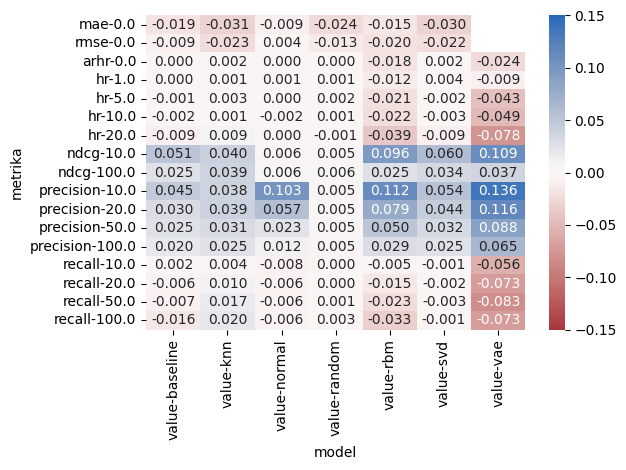

<Figure size 640x480 with 0 Axes>

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_feather("results/metrics.feather")
df = df.replace(["p", "r"], ["precision", "recall"])

df["@k"] = df["@k"].astype(float).fillna(0)

means = (
    df.loc[(df.threshold <= 100), ["metric", "model", "@k", "value", "threshold"]]
    .groupby(["threshold", "model", "metric", "@k"], dropna=False)
    .mean()
)

with pd.option_context("display.max_columns", None, "display.max_rows", None,):
    t = means.T.stack(1, dropna=False).T
    t = t.reindex(index=["predtime", "fittime", 'mae',  'rmse', 'arhr', "hr", "ndcg", "precision", "recall"], level='metric')
    idx = pd.IndexSlice
    t = t.loc[~t.index.get_level_values('metric').isin(['fittime', 'predtime'])]
    cmap = sns.cm.vlag_r
    
    
    y = ["mae", "rmse", "arhr", "hr@1", "hr@5", "hr@10", "hr@20", "ndcg@10", "ndcg@100", "precision@10", "precision@20", "precision@50", "precision@100","recall@10", "recall@20", "recall@50", "recall@100",]
    x = ['baseline', 'knn', 'normal', 'random', 'rbm', 'svd', 'vae']
    g = sns.heatmap(t.loc[(100,)]-t.loc[(20,)], annot=True, fmt=".3f", cmap=cmap, vmin=-0.15, vmax=0.15, xticklabels=x, yticklabels=y)
    g.set_ylabel("metrika")
    g.set_xlabel("model")
    plt.tight_layout()
    plt.show()
    plt.subplots_adjust(left=0.5)
    g.figure.savefig("100-20metrics.pdf")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


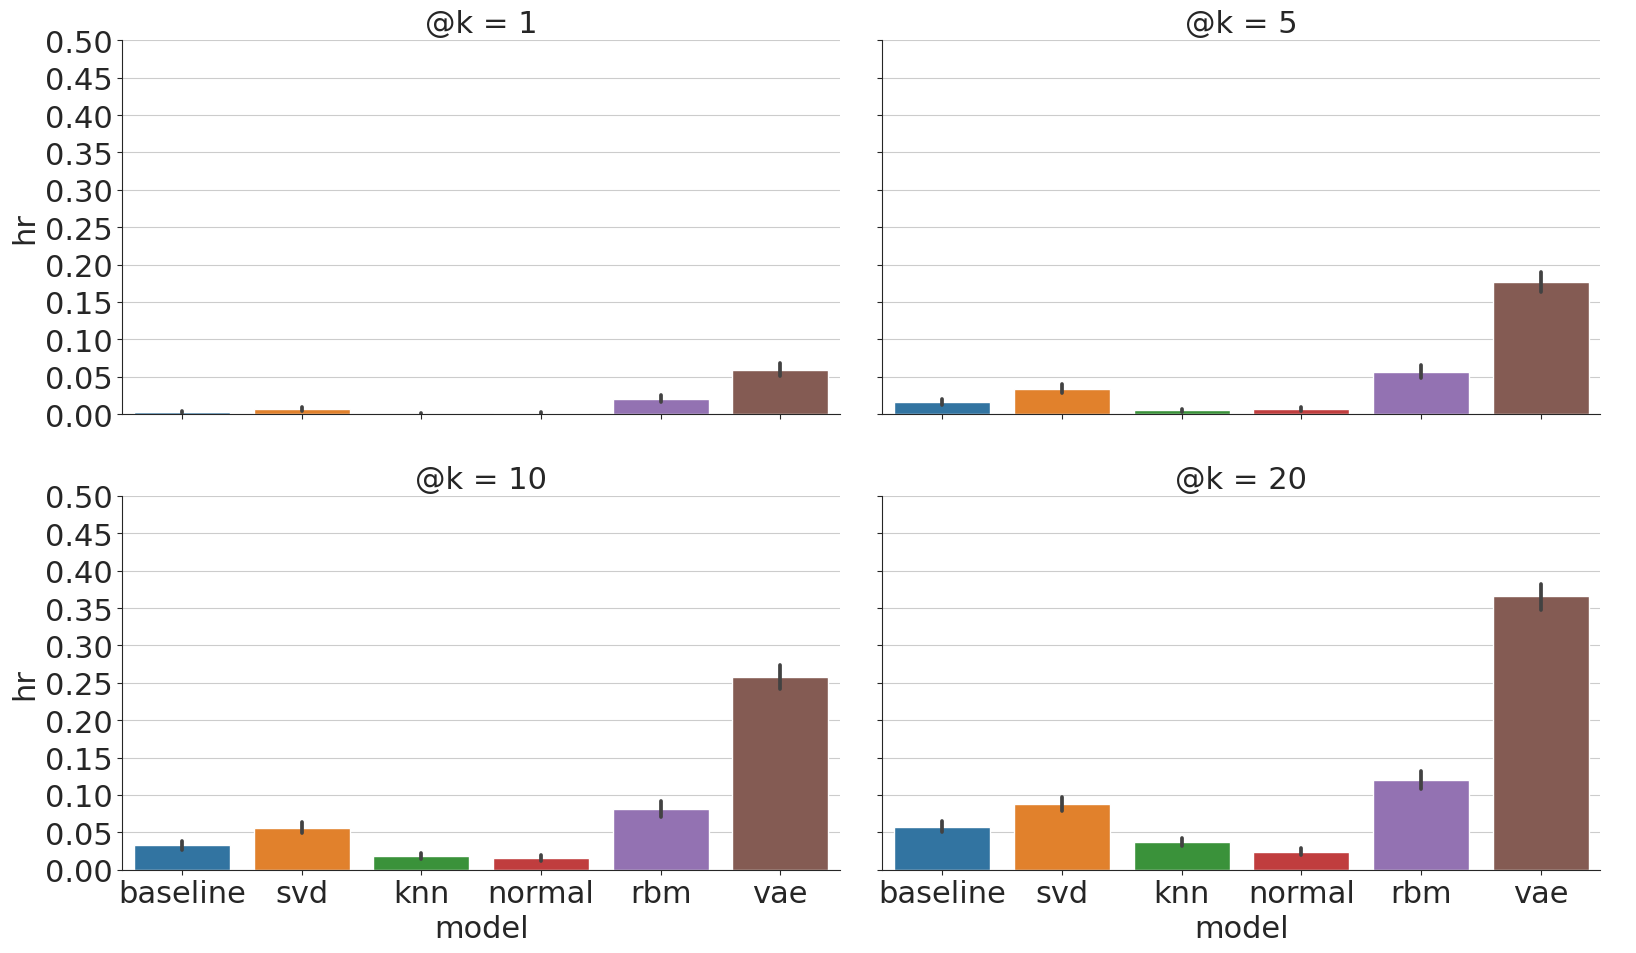

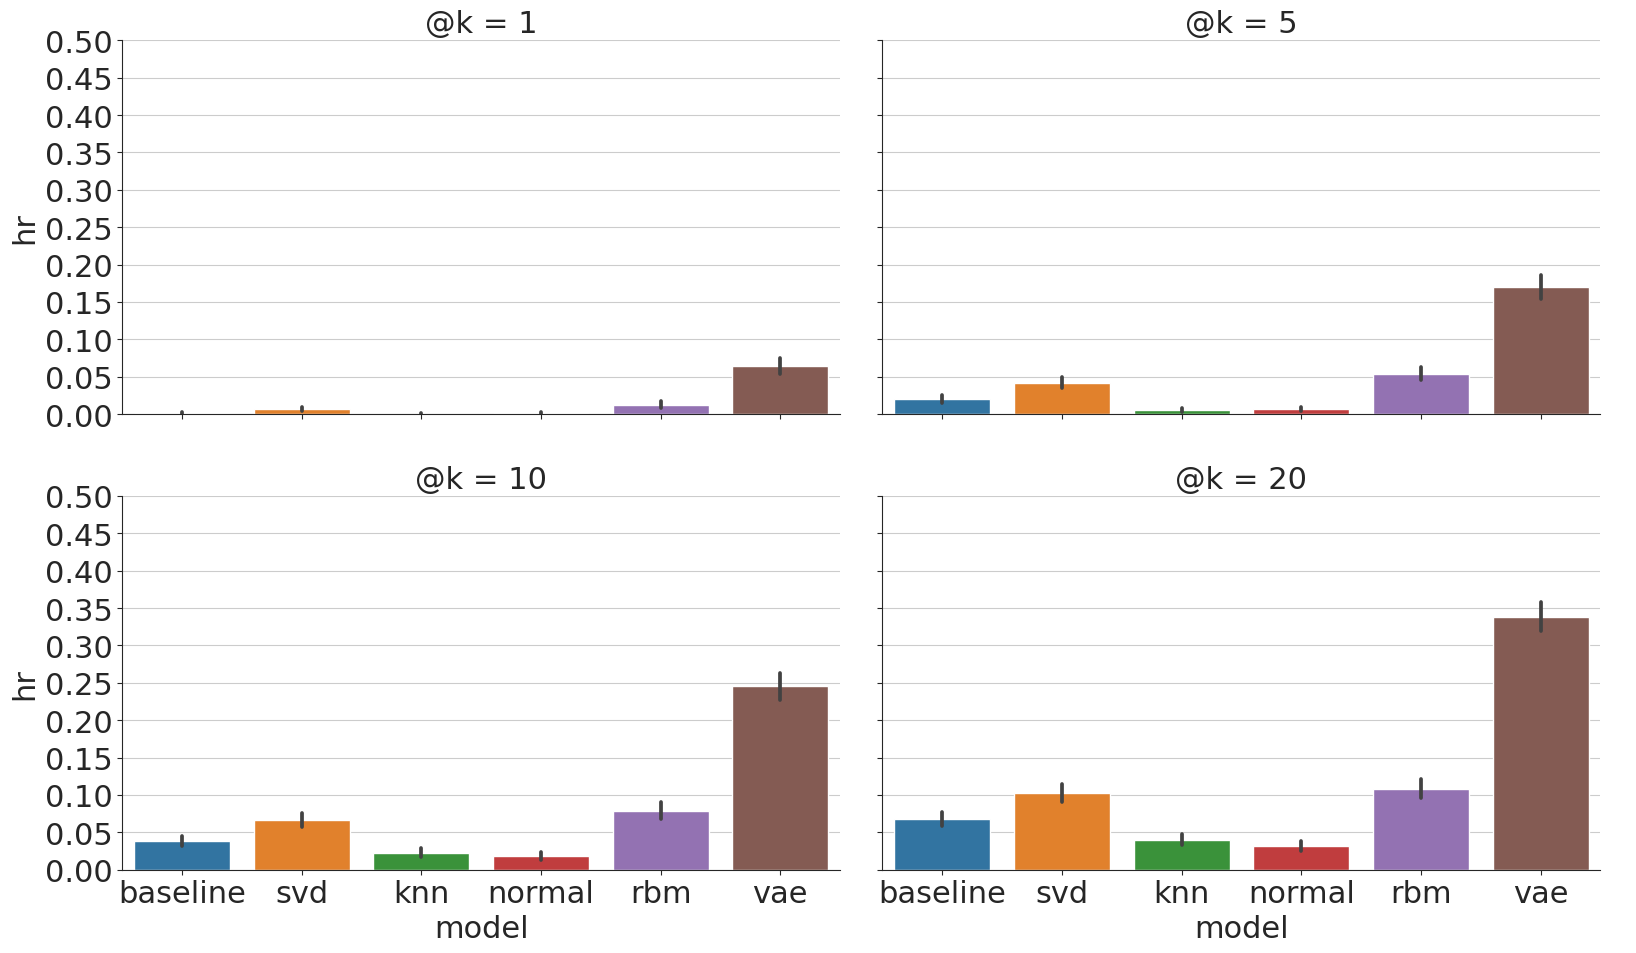

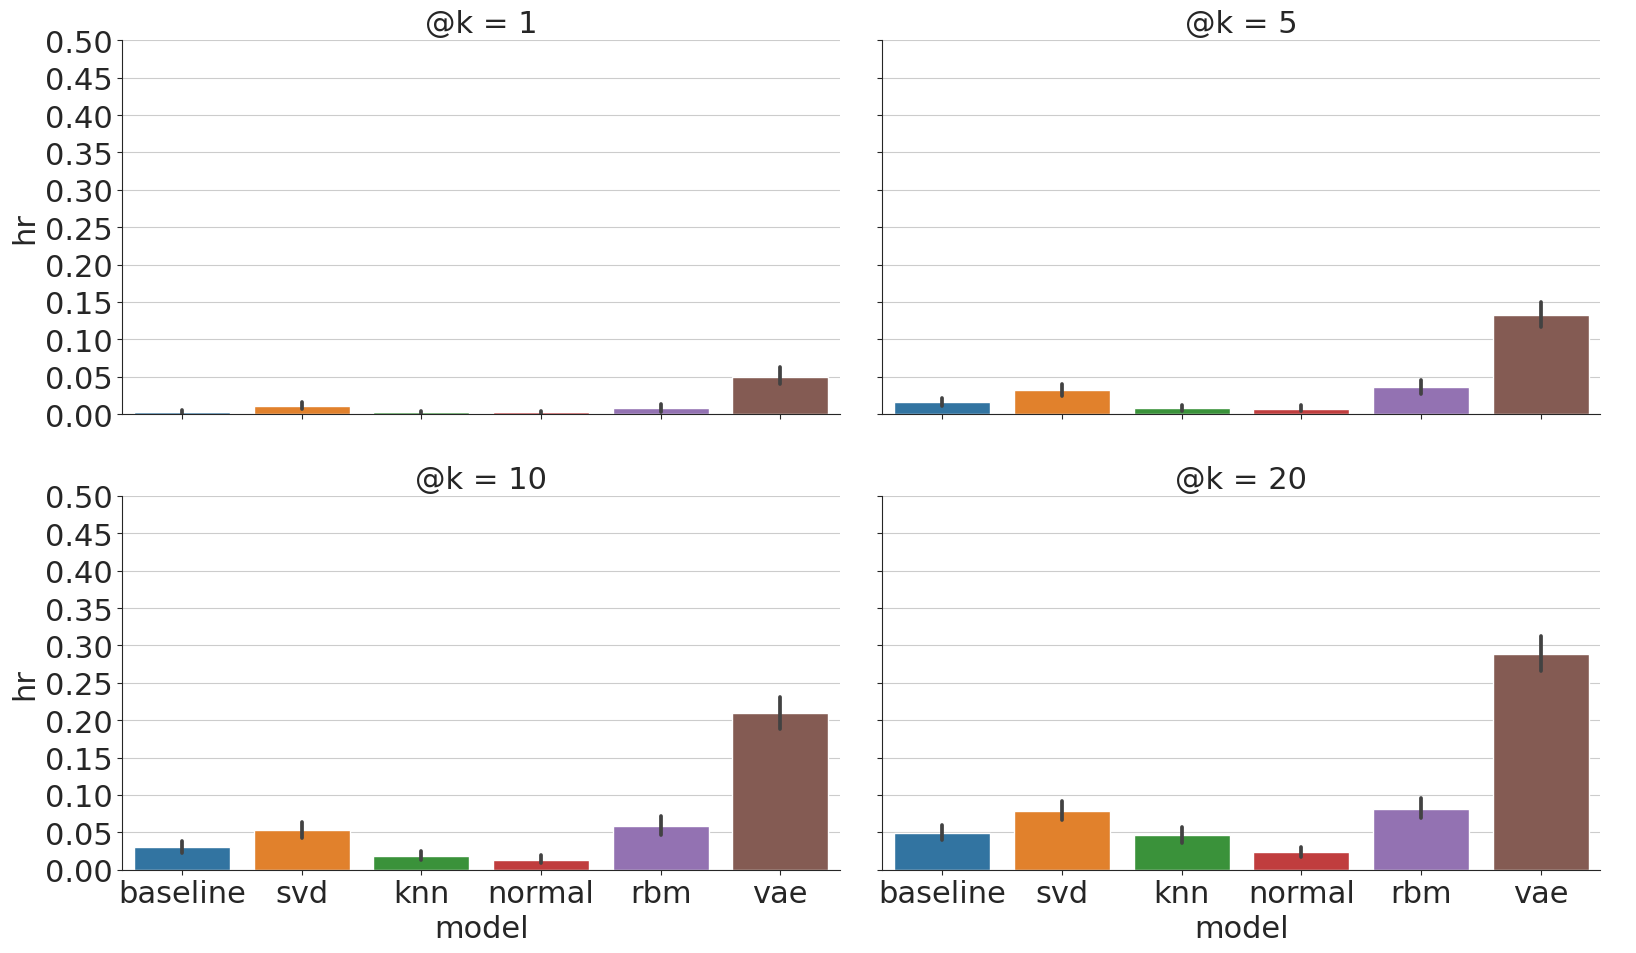

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

sns.set_style("ticks", {"axes.grid": True})


font = {
    "family": "normal",
    #'weight' : 'bold',
    "size": 22,
}

matplotlib.rc("font", **font)


for i in [20, 50, 100]:
    data = df[
        df.metric.isin(["hr"])
        & df.model.isin(["vae", "rbm", "baseline", "svd", "knn", "normal"])
    ]
    data = data.rename(
        columns={"metric": "metrika", "threshold": "granica", "value": "vrednost"}
    )
    data = data[data.granica == i]
    g = sns.catplot(
        data=data,
        kind="bar",
        y="vrednost",
        #col="metrika",
        col_wrap=2,
        col="@k",
        x="model",
        aspect=1.6,
    ).add_legend()
    plt.yticks(np.arange(0, 1, 0.05))
    g.set(ylim=(0, 0.5))
    ticks = data["@k"].unique()
    g.add_legend()
    g.set_ylabels("hr")
    g.fig.savefig(f"hr_{i}.pdf")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = "svd"
metric = "p@10"
drop_unnamed = lambda x: x.loc[:, ~x.columns.str.contains(".*Unnamed.*")]
df1 = pd.read_csv("vae_complete.csv")
df1 = drop_unnamed(df1)
df1 = df1.rename(columns={"num_ratings2": "n_ratings"})
df1 = df1.drop(columns=["num_ratings1"])
df1 = df1.melt(id_vars=["n_ratings"])
df1[["metric", "@k"]] = df1.variable.str.split("@", expand=True)
df1 = df1.drop(columns=["variable"])
df1["model"] = "vae"

df2 = pd.read_csv("recs_loo_complete.csv")
df2 = drop_unnamed(df2)
df2 = df2.rename(columns={"num_ratings2": "n_ratings"})
df2 = df2.melt(id_vars=["n_ratings"])
df2[["model", "metric"]] = df2.variable.str.split("_", expand=True)
df2[["metric", "@k"]] = df2.metric.str.split("@", expand=True)
df2 = df2.drop(columns=["variable"])
df2

df4 = pd.read_csv("recs_rank_complete.csv")
df4 = drop_unnamed(df4)
df4 = df4.rename(columns={"svd_n_ratings1": "n_ratings"})
df4.drop(list(df4.filter(regex = 'ratings1')), axis = 1, inplace = True)
df4 = df4.melt(id_vars=["n_ratings"])
df4[["model", "metric"]] = df4.variable.str.split("_", expand=True)
df4[["metric", "@k"]] = df4.metric.str.split("@", expand=True)
df4 = df4.drop(columns=['variable'])
df4

df3 = pd.read_csv("rbm_complete.csv")
df3 = df3.rename(columns={"n_ratings3": "n_ratings"})
df3 = drop_unnamed(df3)
df3 = df3.drop(columns=["n_ratings2", "n_ratings1"])
df3 = df3.melt(id_vars=["n_ratings"])
df3["model"] = "rbm"
df3[["metric", "@k"]] = df3.variable.str.split("@", expand=True)
df3 = df3.drop(columns="variable")
df = pd.concat([df1, df2, df3, df4])

df.reset_index().to_feather("res_with_num_ratings.feather")
df[["model", "metric"]].drop_duplicates()

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

metric = 'arhr'
k = None
b = [20] + [10 * (2**x) for x in range(2, 8)]
#b = np.arange(0,3000,200)

sns.set_style("ticks", {"axes.grid": True})

df = pd.read_feather("res_with_num_ratings.feather")
df["@k"].fillna(0,inplace=True)
df['@k'] = df["@k"].astype(int)
#df["bins"] = pd.cut(df.n_ratings, b)
data = df[(df.model != "random") & (df.metric == f"{metric}")]

if k != None:
    data = data[data["@k"] == k]

data = data.reset_index()

data = (
    data.groupby(["bins", "model"])
    .agg({"value": "mean"})
    .reset_index(level=[0, 1])
    .dropna()
    .rename(columns={'value':f'{metric}', 'bins' : 'ocene'})
)

font = {
    "family": "normal",
    "size": 20,
}

matplotlib.rc("font", **font)

#sns.color_palette("rocket", as_cmap=True)
g = sns.catplot(
    data=data,
    kind="point",
    col="model",
    x="n_ratings",
    y=f"{metric}",
    col_wrap=2,
    aspect=2,
    dodge=False,
    hue = 'model',
)

g.set_xticklabels([f"{b[i]}-{b[i+1]}" for i in range(0,len(b)-1)], rotation=30)
g.figure.savefig("coldStart_arhr.pdf")
# sns.barplot(data[f"{model}_{metric}"])